In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys
import math
import os

In [3]:
from scipy.stats import multivariate_normal

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
class Obj:
    pass

In [6]:
params = Obj()
params.input_dim = 784
params.hidden_encoder_dim = 400
params.hidden_decoder_dim = 400
params.latent_dim = 2
params.lam = 0

In [7]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.001)
  return tf.Variable(initial)

In [8]:
def bias_variable(shape):
  initial = tf.constant(0., shape=shape)
  return tf.Variable(initial)

In [9]:
x = tf.placeholder("float", shape=[None, params.input_dim])
l2_loss = tf.constant(0.0)

In [10]:
# Hidden layer encoder
W_encoder_input_hidden = weight_variable([params.input_dim, params.hidden_encoder_dim])
l2_loss += tf.nn.l2_loss(W_encoder_input_hidden)
b_encoder_input_hidden = bias_variable([params.hidden_encoder_dim])
l2_loss += tf.nn.l2_loss(b_encoder_input_hidden)
hidden_encoder = tf.nn.relu(tf.matmul(x, W_encoder_input_hidden) + b_encoder_input_hidden)

In [11]:
# Mu encoder
W_encoder_hidden_mu = weight_variable([params.hidden_encoder_dim, params.latent_dim])
l2_loss += tf.nn.l2_loss(W_encoder_hidden_mu)
b_encoder_hidden_mu = bias_variable([params.latent_dim])
l2_loss += tf.nn.l2_loss(b_encoder_hidden_mu)
mu_encoder = tf.matmul(hidden_encoder, W_encoder_hidden_mu) + b_encoder_hidden_mu

In [12]:
# Sigma encoder
W_encoder_hidden_logvar = weight_variable([params.hidden_encoder_dim, params.latent_dim])
l2_loss += tf.nn.l2_loss(W_encoder_hidden_logvar)
b_encoder_hidden_logvar = bias_variable([params.latent_dim])
l2_loss += tf.nn.l2_loss(b_encoder_hidden_logvar)
logvar_encoder = tf.matmul(hidden_encoder, W_encoder_hidden_logvar) + b_encoder_hidden_logvar

In [13]:
# Sample epsilon
epsilon = tf.random_normal(tf.shape(logvar_encoder), name='epsilon')
# Sample latent variable
std_encoder = tf.exp(0.5 * logvar_encoder)
z = mu_encoder + tf.multiply(std_encoder, epsilon)

In [14]:
# Hidden layer decoder
W_decoder_z_hidden = weight_variable([params.latent_dim, params.hidden_decoder_dim])
l2_loss += tf.nn.l2_loss(W_decoder_z_hidden)
b_decoder_z_hidden = bias_variable([params.hidden_decoder_dim])
l2_loss += tf.nn.l2_loss(b_decoder_z_hidden)
hidden_decoder = tf.nn.relu(tf.matmul(z, W_decoder_z_hidden) + b_decoder_z_hidden)

In [15]:
# Reconstruction layer 
W_decoder_hidden_reconstruction = weight_variable([params.hidden_decoder_dim, params.input_dim])
l2_loss += tf.nn.l2_loss(W_decoder_hidden_reconstruction)
b_decoder_hidden_reconstruction = bias_variable([params.input_dim])
l2_loss += tf.nn.l2_loss(b_decoder_hidden_reconstruction)
x_hat_logit = tf.matmul(hidden_decoder, W_decoder_hidden_reconstruction) + b_decoder_hidden_reconstruction

## Loss

In [16]:
# Loss
# KL Divergence (Log Guassian)
KLD = -0.5 * tf.reduce_sum(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
# Reconstruction Loss
BCE = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat_logit, labels=x), reduction_indices=1)
loss = tf.reduce_mean(BCE + KLD)
regularized_loss = loss + params.lam * l2_loss

## Train

In [17]:
# Train
loss_summ = tf.summary.scalar("lowerbound", loss)
train_step = tf.train.AdamOptimizer(0.01).minimize(regularized_loss)
# add op for merging summary
summary_op = tf.summary.merge_all()

In [18]:
## 

In [19]:
# add Saver ops
saver = tf.train.Saver()

In [117]:
n_steps = 300 #int(1e6)
batch_size = 100

In [118]:
sess = tf.InteractiveSession()

In [119]:
summary_writer = tf.summary.FileWriter('experiment',
                                      graph=sess.graph)
if os.path.isfile("save/model.ckpt"):
    print("Restoring saved parameters")
    saver.restore(sess, "save/model.ckpt")
else:
    print("Initializing parameters")
    sess.run(tf.global_variables_initializer())

for step in range(1, n_steps):
    batch = mnist.train.next_batch(batch_size)
    feed_dict = {x: batch[0]}
    _, cur_loss, summary_str = sess.run([train_step, loss, summary_op], feed_dict=feed_dict)
    summary_writer.add_summary(summary_str, step)

    if step % 50 == 0:
        save_path = saver.save(sess, "save/model.ckpt")
        sys.stdout.write("\rStep {0} | Loss: {1}".format(step, cur_loss))


Initializing parameters
Step 250 | Loss: 187.84906005859375

In [120]:
liste_z = z.eval(feed_dict={x: batch[0]})

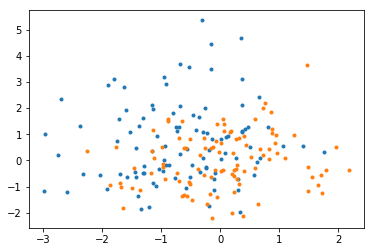

In [121]:
plt.plot(liste_z[:,0], liste_z[:,1], '.')
ref = np.random.randn(batch_size, params.latent_dim)
plt.plot(ref[:,0], ref[:,1], '.')

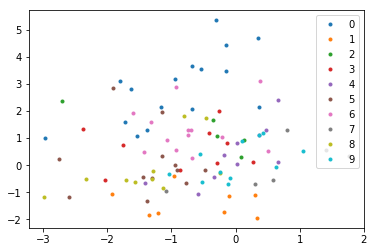

In [122]:
z_cat = {}
for i in range(10):
    z_cat[i] = []
for i in range(len(liste_z)):
    index = np.where(batch[1][i] == 1)[0][0]
    z_cat[index] += [liste_z[i]]
for i in range(10):
    z_aff = np.transpose(z_cat[i])
    plt.plot(z_aff[0,:], z_aff[1,:], '.')
plt.legend((0,1,2,3,4,5,6,7,8,9))

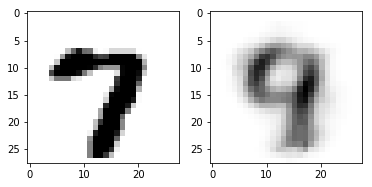

In [127]:
x_hat = tf.nn.sigmoid(x_hat_logit).eval(feed_dict={x: batch[0]})
i = 0
plt.subplot(1,2,1)
plt.imshow(batch[0][i].reshape((28, 28)), cmap = 'gray_r')
plt.subplot(1,2,2)
plt.imshow(x_hat[i].reshape((28, 28)), cmap = 'gray_r')


categ =  5
mu =  [ 0.93044049 -0.37222153]
std =  [ 0.82243657  0.72555733]


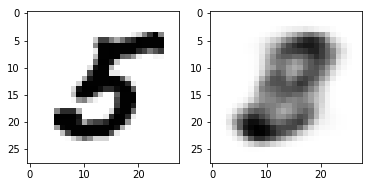

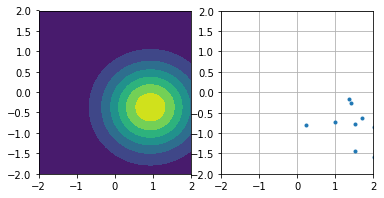

In [128]:

x_hat = tf.nn.sigmoid(x_hat_logit).eval(feed_dict={x: batch[0]})

i = 1
plt.figure()
plt.subplot(1,2,1)
plt.imshow(batch[0][i].reshape((28, 28)), cmap = 'gray_r')
plt.subplot(1,2,2)
plt.imshow(x_hat[i].reshape((28, 28)), cmap = 'gray_r')

print('categ = ', np.where(batch[1][i] == 1)[0][0])
mu_test = mu_encoder.eval(feed_dict={x: batch[0] * 0})[i]
print('mu = ', mu_test)
std_test = std_encoder.eval(feed_dict={x: batch[0] * 0})[i]
print('std = ', std_test)
axe_x, axe_y = np.mgrid[-2:2:.01, -2:2:.01]
q = multivariate_normal(mu_test, std_test**2 * np.eye(2))
pos = np.empty(axe_x.shape + (2,))
pos[:, :, 0] = axe_x; pos[:, :, 1] = axe_y

plt.figure(figsize = (6, 3))
plt.subplot(1,2,1)
plt.contourf(axe_x, axe_y, q.pdf(pos))
ax = plt.subplot(1,2,2)
spl = q.rvs(10)
plt.plot(spl[:,0], spl[:,1], '.')
plt.plot(liste_z[i,0], liste_z[i,1], 'xr')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
ax.yaxis.grid(True)
ax.xaxis.grid(True)

In [92]:
q.entropy()

2.0394987431609497

In [98]:
q.entropy()

-0.22137997952224353

In [107]:
0.5 * np.log( np.prod( 2 * np.pi * np.e * std_test**2))

-0.22138001024723053

In [102]:
np.linalg.det(std_test**2 * np.eye(2))

0.0022017250948597462

In [105]:
np.prod(std_test**2)

0.002201725

In [113]:
0.5 * np.log( np.prod( 2 * np.pi * np.e * np.array([0.0001, 0.0001])))

-6.3724633055668374

In [3]:
import numpy as np
np.log(10)

2.3025850929940459